# Project : The readmission of diabetic patients

Our project will focus on the readmission of diabetic patients.Indeed, this is an interesting and topical subject that can affect each of us, it is mainly this reason that we decided to study it. 
Throughout this study, Markdowns and comments will be written in order to facilitate understanding of the analysis and guide the reader on the progress of our reasoning.

At first, we need to import tools to study our dataset therefore we will import librabries and metrics

In [1]:
!pip install imbalanced-learn
!pip install xgboost
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Import necessary metrics
import sklearn.metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Opening of the dataset and analyze of the content of the data

In [2]:
# Load the dataset and print Row and colums
df= pd.read_csv('diabetic_data.csv', delimiter=',')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 101766 rows and 50 columns


In [3]:
#displaying first 5 rows of data to allow us to concretely visualize the different characteristics of the data
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# define the type of the variable to understand what the data type is.
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

Optimization of the dataset

In [5]:
#This code aims to identify and display values, variable names as well as their frequencies for columns where the value appears more than 101750 times. 
#This will allow us to eliminate variables that do not interest us because these variables are present in almost 100% of patients in the database.
for i in df.columns:
    if np.array(df[i].value_counts())[0]>101750:
        print(df[i].value_counts())

No        101765
Steady         1
Name: acetohexamide, dtype: int64
No        101763
Steady         3
Name: troglitazone, dtype: int64
No    101766
Name: examide, dtype: int64
No    101766
Name: citoglipton, dtype: int64
No        101753
Steady        13
Name: glipizide-metformin, dtype: int64
No        101765
Steady         1
Name: glimepiride-pioglitazone, dtype: int64
No        101764
Steady         2
Name: metformin-rosiglitazone, dtype: int64
No        101765
Steady         1
Name: metformin-pioglitazone, dtype: int64


In [6]:
#cleaning the data to no longer have a duplicate
print('Total data = ', len(df))
print('Unique entries = ', len(np.unique(df['patient_nbr'])))
df.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(df))

Total data =  101766
Unique entries =  71518
Length after removing Duplicates: 71518


In [7]:
#delete the duplicate variable in the dataset
df.drop(['glimepiride-pioglitazone','metformin-pioglitazone','patient_nbr','encounter_id','acetohexamide','troglitazone','examide','citoglipton'],axis=1,inplace=True)

In [8]:
#this code replaces all occurrences of the string '?' by NaN values in your DataFrame, which is often used to deal with missing values in data.
df.replace('?',np.nan,inplace=True)

In [9]:
#In summary, this code helps identify columns in a DataFrame that contain at least one missing value 
#and displays the percentage of missing values for each of these columns.
for i in df.columns:
    if df[i].isna().sum()>0:
        print(i,df[i].isna().sum()*100/len(df))

race 2.7237898151514304
weight 96.0107944853044
payer_code 43.4058558684527
medical_specialty 48.20744427976174
diag_1 0.01538074330937666
diag_2 0.41108532117788527
diag_3 1.7128555049078553


In [10]:
# we will delete data when the percentage of missing data is too high
df.drop(['payer_code','medical_specialty','weight'],axis=1,inplace=True)

In [11]:
#This code removes all rows in the DataFrame df that contain at least one missing value (NaN) 
#and modifies the original DataFrame accordingly.
df.dropna(inplace=True)

In [12]:
#This line of code counts the number of missing values in the 'race' column of the DataFrame df.
#The number being equal to 0 this variable is interesting so we can study this data
df['race'].isna().sum()

0

In [13]:
#This line of code modifies the DataFrame df keeping only the rows where the value in the 'gender' column is not equal to 'Unknown/Invalid'.
df=df[df.gender!='Unknown/Invalid']

Now, We will start by searching for basic information

In [14]:
# number of women and men in readmission
df['gender'].value_counts()

Female    36440
Male      31917
Name: gender, dtype: int64

In [15]:
#number of people readmitted more than 30 and less than 30
df.readmitted.value_counts()

NO     40728
>30    21539
<30     6090
Name: readmitted, dtype: int64

Formatting data

In [16]:
#This line of code converts the values of the 'readmitted' column in the DataFrame df. 
#If a value is equal to '<30', it is replaced by 1; otherwise, it is replaced by 0.
df.readmitted = [1 if each=='<30' else 0 for each in df.readmitted]

In [17]:
#this code replaces the age intervals in the 'age' column of the DataFrame df 
#with specific numeric values defined in the replaceDict dictionary
replaceDict = { '[0-10)' : 0,
                '[10-20)' : 1, 
                '[20-30)' : 2, 
                '[30-40)' : 3, 
                '[40-50)' : 4, 
                '[50-60)' : 5,
                '[60-70)' : 6, 
                '[70-80)' : 7,
                '[80-90)' : 8,
                '[90-100)' : 9}

df['age'] = df['age'].apply(lambda x : replaceDict[x])

In [18]:
#gives the ages of all patients according to the age interval described above
df['age']

1         1
2         2
3         3
4         4
5         5
         ..
101754    7
101755    4
101756    6
101758    8
101765    7
Name: age, Length: 68357, dtype: int64

# 1-Analysis and visualization of our first studies

In [19]:
# we copy the data to not damage our work done previously and draw our correlation graph
data=df.copy()

In [20]:
#Display database variables
data[~data.applymap(np.isreal).all(1)]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,1,1,1,7,3,59,0,18,...,No,No,No,Up,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,2,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,3,1,1,7,2,44,1,16,...,No,No,No,Up,No,No,No,Ch,Yes,0
4,Caucasian,Male,4,1,1,7,1,51,0,8,...,No,No,No,Steady,No,No,No,Ch,Yes,0
5,Caucasian,Male,5,2,1,2,3,31,6,16,...,No,No,No,Steady,No,No,No,No,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,7,1,1,7,9,50,2,33,...,No,No,No,Steady,No,No,No,Ch,Yes,0
101755,Other,Female,4,1,1,7,14,73,6,26,...,No,No,No,Up,No,No,No,Ch,Yes,0
101756,Other,Female,6,1,1,7,2,46,6,17,...,No,No,No,Steady,No,No,No,No,Yes,0
101758,Caucasian,Female,8,1,1,7,5,76,1,22,...,No,No,No,Up,No,No,No,Ch,Yes,0


A-Age

we can see a strong readmission for intervals 5 to 8 which corresponds to 50 to 80 years. What seemed logistical to us according to our first ideas and our documentary

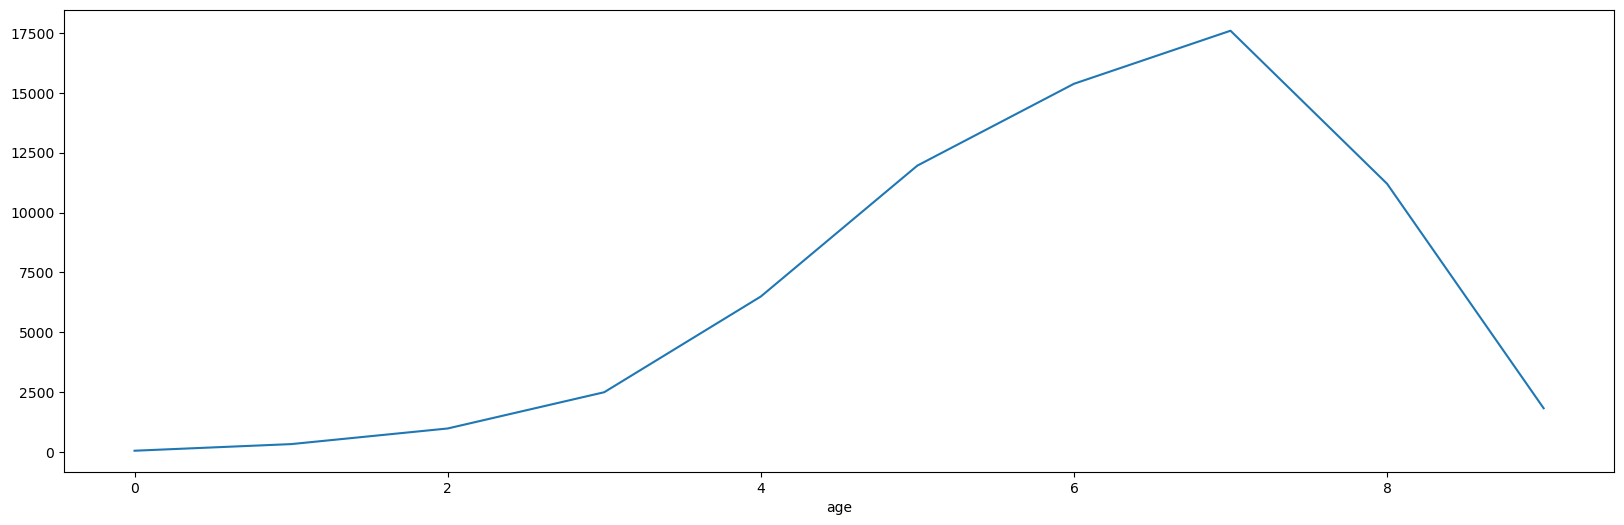

In [21]:
data.groupby("age")["age"].count().plot(kind='line',figsize= (20,6))
plt.show()

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

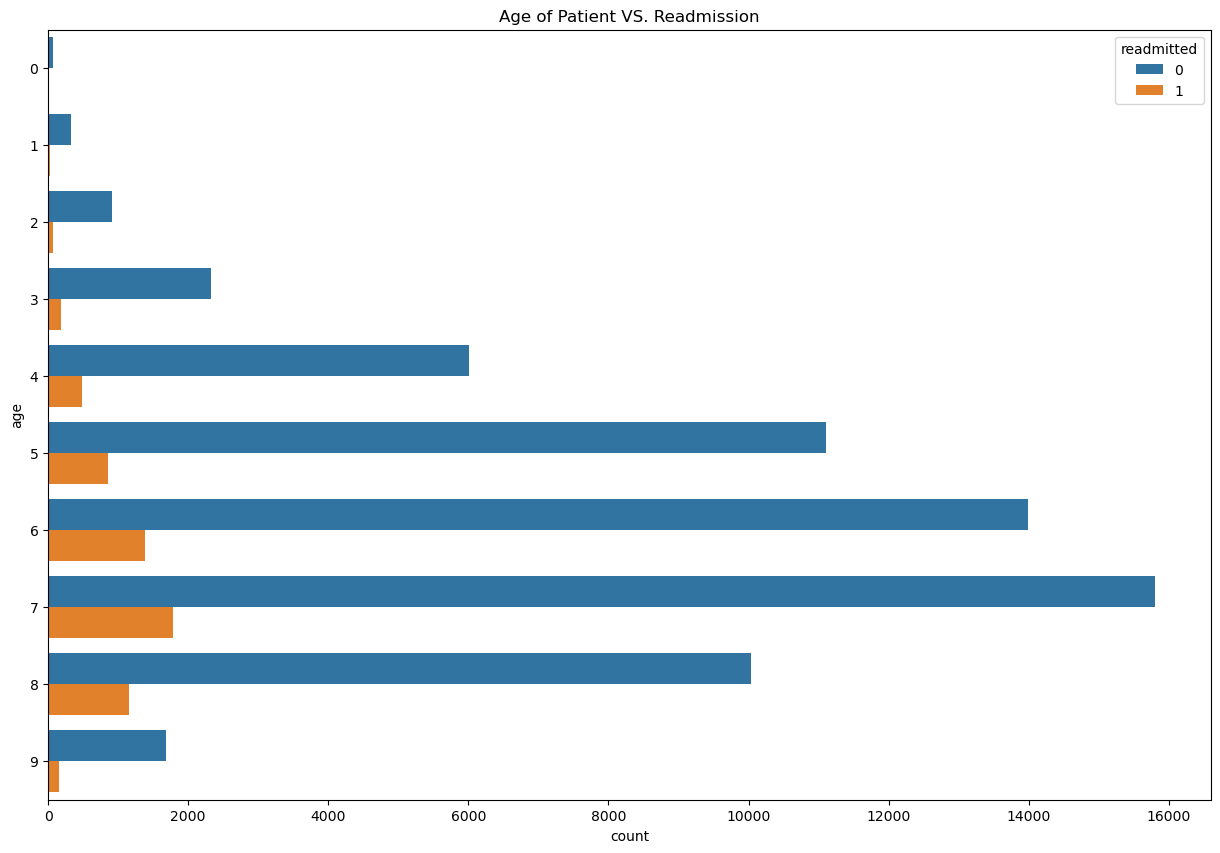

In [22]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')
#Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)


B-Gender

we can see very similar readmittance rate figures between men and women. What seemed logistical to us according to our first ideas and our documentary

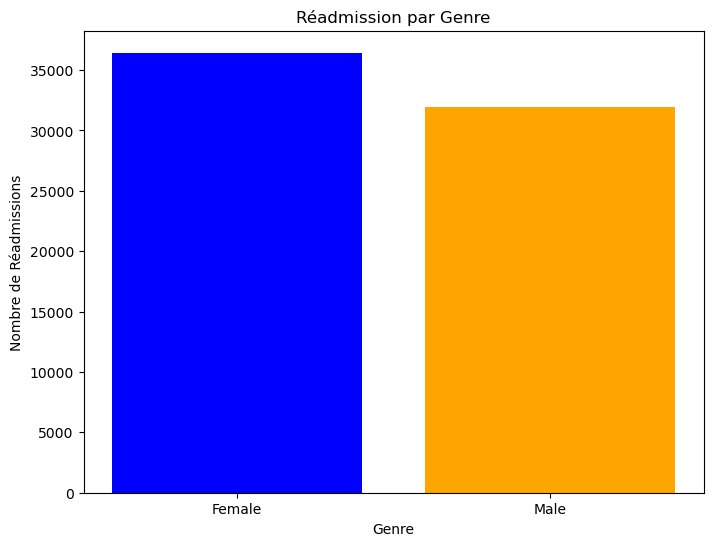

In [23]:
# Filter the data for readmitted cases and group by gender

readmitted_counts = df[df['readmitted'] != 'NO'].groupby('gender').size().reset_index(name='count')

# Create a bar plot to visualize readmissions by gender using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(readmitted_counts['gender'], readmitted_counts['count'], color=['blue', 'orange'])
plt.title('Réadmission par Genre')
plt.xlabel('Genre')
plt.ylabel('Nombre de Réadmissions')
plt.show()
#blue:women and orange:men

C- Time

For 5% of patients the duration in hospital does not exceed 2 days. Then we can see in the second graph that the non-readmitted people stay longer between 0 and 4 days but from 4 days onwards those are the readmitted people who stay longer.

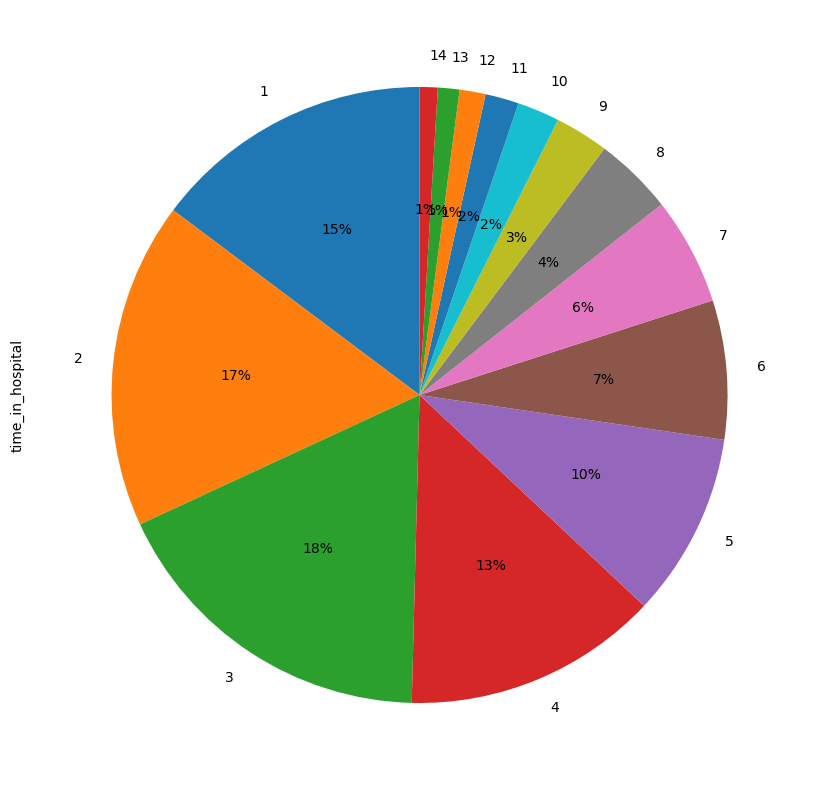

In [24]:
time_in_hospital=pd.DataFrame(df["time_in_hospital"]).groupby("time_in_hospital")["time_in_hospital"].count()
time_in_hospital.plot(kind='pie', subplots=True, shadow = False,autopct='%1.0f%%',startangle=90,figsize=(15,10))
plt.show()
# time (days) in hospital depending on the number of people

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

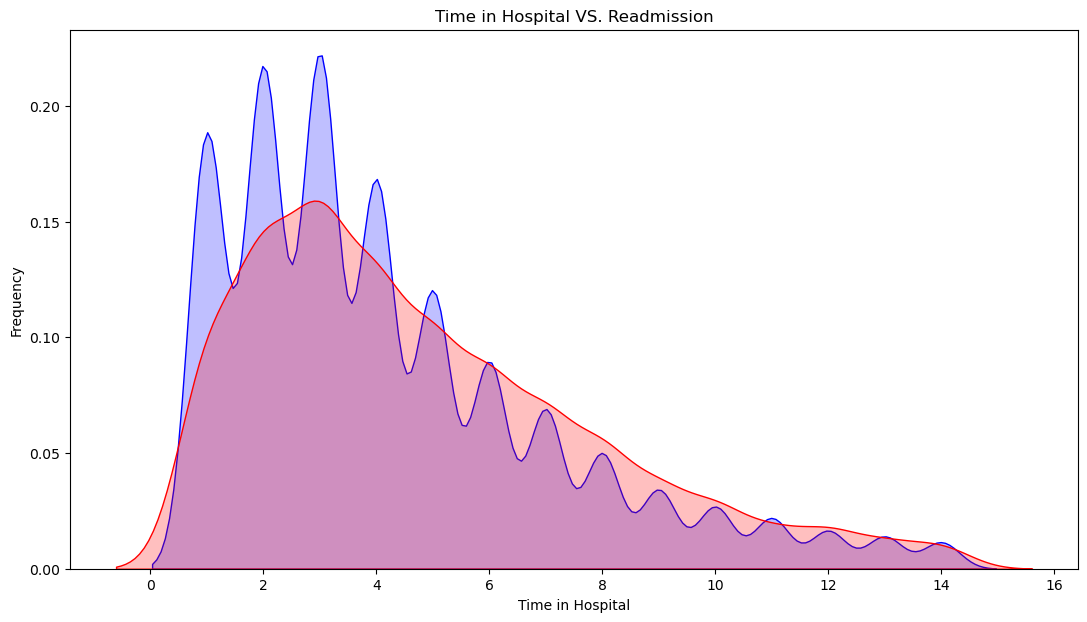

In [25]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

D-Number of medications

we can see that patients admitted or not consume approximately the same number of medications

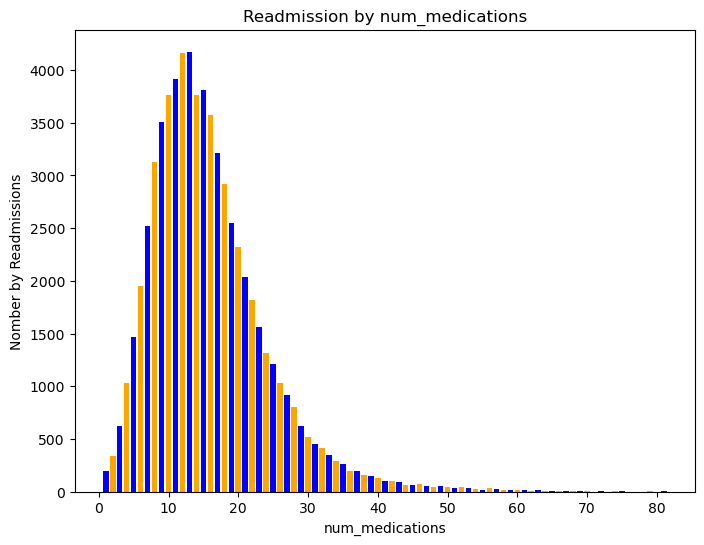

In [26]:
# Filter the data for readmitted cases and group by num_medications

readmitted_counts = df[df['readmitted'] != 'NO'].groupby('num_medications').size().reset_index(name='count')

# Create a bar plot to visualize readmissions by gender using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(readmitted_counts['num_medications'], readmitted_counts['count'], color=['blue', 'orange'])
plt.title('Readmission by num_medications')
plt.xlabel('num_medications')
plt.ylabel('Nomber by Readmissions')
plt.show()
#blue:readmitted and orange:no readmitted 

E- Number of lab procedure

the curves are generally similar although there is a higher frequency of non-readmitted people who have less care and more readmitted people who have more care. (We see it at the ends)

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

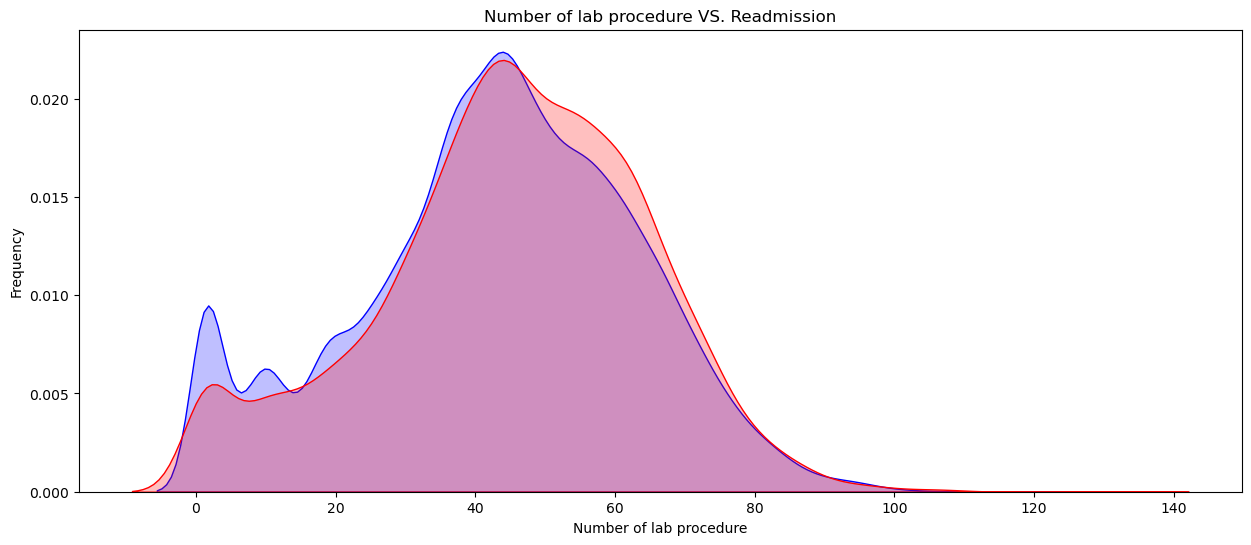

In [27]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

# 2-In-depth study

A-Ethnic groups

A surprising finding was the differences in readmission rates based on ethnicity. We therefore decided to look into the subject and find the reasons why certain ethnicities have a higher readmission rate. This is certainly due to diet, fast food, living conditions and genes predisposing to diabetes, access to the medical center...

<AxesSubplot:xlabel='count', ylabel='race'>

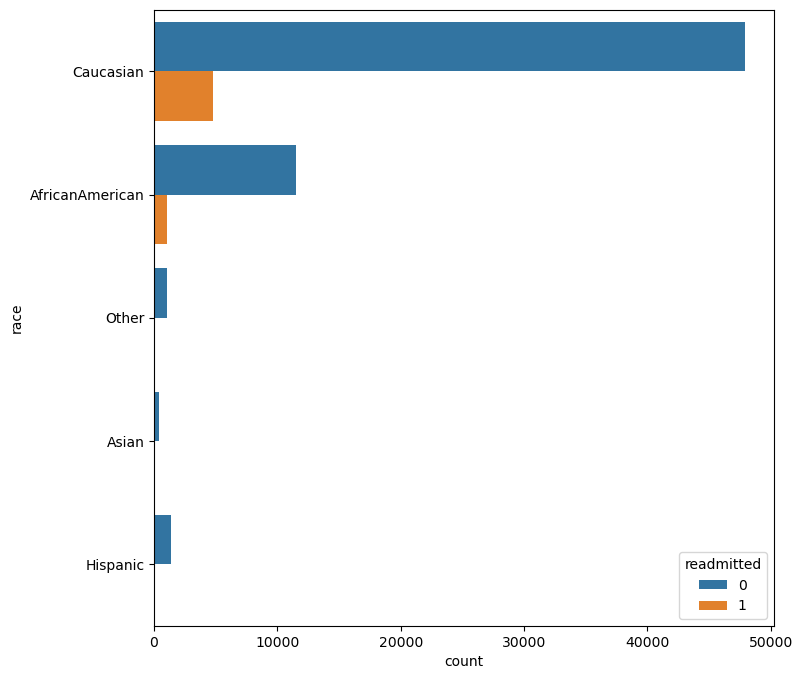

In [28]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['race'], hue = df['readmitted'])
#0 caucasian
#1 afro-american
#2 others
#3 asian
#4 Hispanic

B-Correlation matrix

In [38]:
#This code preprocesses a set of data related to diabetic patient files
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin", "metformin-rosiglitazone"]:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)


data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [39]:
# , the code aims to group medical diagnoses into more general categories to simplify the analysis of medical data. 
#Categories include areas such as circulatory, respiratory, digestive problems, diabetes-related diagnoses, injuries, musculoskeletal problems, genitourinary problems, neoplasms, pregnancy-related diagnoses, and other grouped diagnoses under the 'other' category.
data['diag_1'] = data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_2'] = data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_3'] = data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [40]:
#This code applies the Label Encoding transformation to all columns in the DataFrame df. This is useful when you have categorical columns (for example, text strings) in your dataset and you want to convert them to numeric values for use. 
#Each unique value in each categorical column is replaced by a unique integer.
Transformer=LabelEncoder()
for col in df.columns:
    Transformer.fit(df[col]) 
    df[col]=Transformer.fit_transform(df[col])

In [41]:
#This code applies the Label Encoding transformation to the columns specified in the columns list of the DataFrame data. 
#This is useful when you have categorical columns in your dataset and want to convert them to numeric values
columns=['race','gender','diag_1','diag_2','diag_3']
Transformer=LabelEncoder()
for col in columns:
    Transformer.fit(data[col]) 
    data[col]=Transformer.fit_transform(data[col])



In [42]:
# Display types of the variables of the database that it transforms in integer
data.dtypes

race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
diag_1                      int32
diag_2                      int32
diag_3                      int32
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
pioglitazone                int64
rosiglitazone               int64
acarbose      

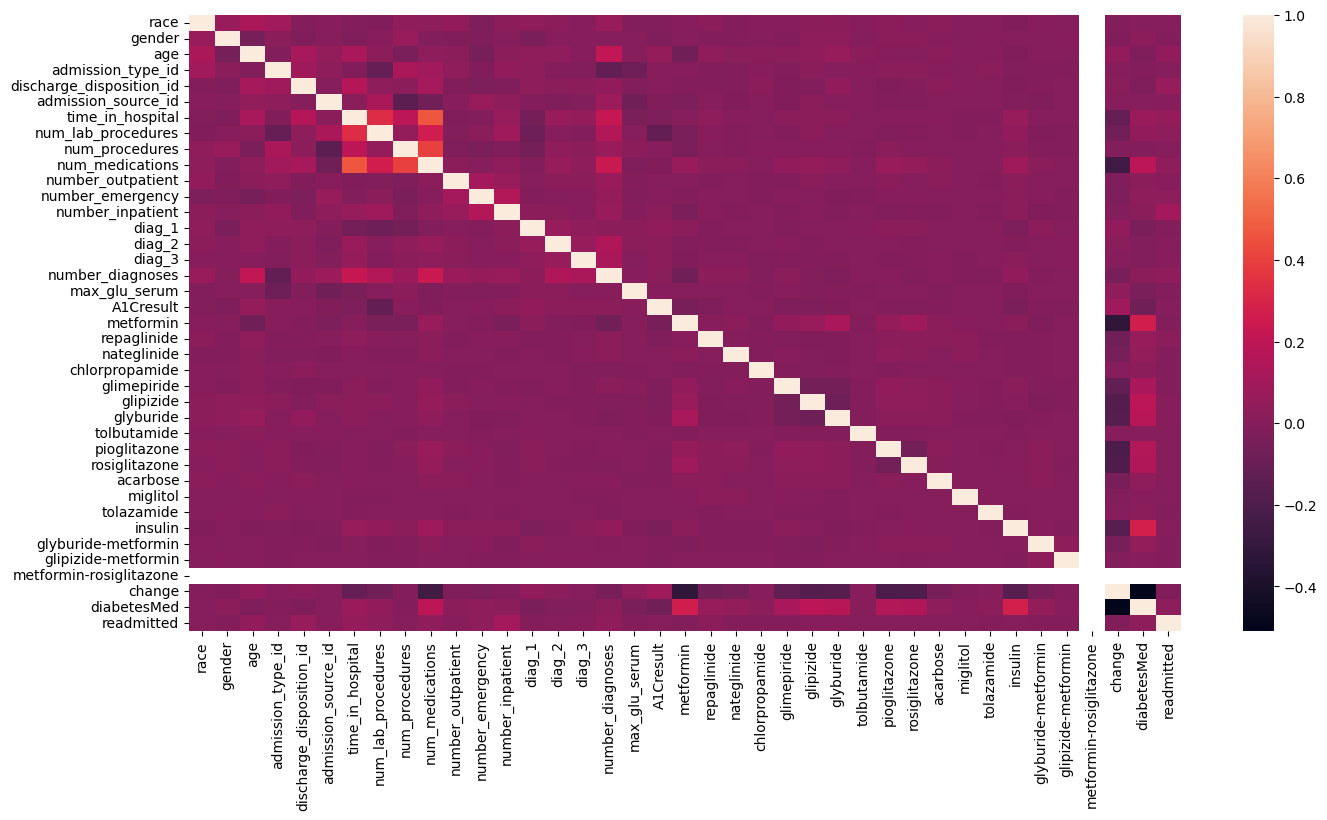

In [43]:
plt.figure(figsize=(16,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.show()

# 3- Classification

In [44]:
#Evaluate the performance of a binary classification model by calculating various metrics and displaying AUC. 
#This metric is commonly used to evaluate the quality of a classification model's predictions.
def res_metrics(X_act,y_act, y_pred, thresh=0.5):
    auc = roc_auc_score(y_act, y_pred)
    accuracy = accuracy_score(y_act, (y_pred > thresh))
    recall = recall_score(y_act, (y_pred > thresh))
    precision = precision_score(y_act, (y_pred > thresh))
    f1score = f1_score(y_act,(y_pred > thresh) )
    specificity = sum((y_pred < thresh) & (y_act == 0)) /sum(y_act ==0)
    r2score=r2_score(y_act, y_pred)
    ar2_score=1 - (1-r2_score(y_act, y_pred))*(len(y_act)-1)/(len(y_act)-X_act.shape[1]-1)
    mae=mean_absolute_error(y_act, y_pred)
    mse=sklearn.metrics.mean_squared_error(y_act, y_pred)
    rmse=np.sqrt(sklearn.metrics.mean_squared_error(y_act, y_pred))
    res=pd.DataFrame({
    'Metrics': ['AUC', 'Accuracy', 'Recall', 'Precision','F1 score','Specificity','R^2','Adjusted R^2','Mean Absolute Error','Mean Squared Error','Rooted Mean Square Error'],
    'Results': [round(auc,3),round(accuracy,3),round(recall,3),round(precision,3),round(f1score,3),round(specificity,3),round(r2score,3),round(ar2_score,3),round(mae,3),round(mse,3),round(rmse,3)]})
    res.set_index('Metrics',inplace=True)
    return res


    return

In [45]:
#This code divides the data into training and test sets, and prints the dimensions of these sets. 
#Dividing into training and testing sets helps estimate the model's ability to generalize to new data.
X, y = data.loc[:,data.columns!='readmitted'],data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45091, 38) (22209, 38) (45091,) (22209,)


In [46]:
#This code applies standard scaling to the training (X_train) and test (X_test) datasets. 
#This involves centering the data around zero (zero mean) and scaling it by dividing by its standard deviation, which helps ensure a standard distribution for each characteristic.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Classification Logistic Regression

In [47]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
lr_res=res_metrics(X_test,y_test,y_pred)
lr_res

,Results
Metrics,
AUC,0.502
Accuracy,0.907
Recall,0.004
Precision,0.471
F1 score,0.008
Specificity,1.000
R^2,-0.103
Adjusted R^2,-0.105
Mean Absolute Error,0.093


Classification Random Forest

In [48]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_res=res_metrics(X_test,y_test,y_pred)
rf_res

,Results
Metrics,
AUC,0.501
Accuracy,0.907
Recall,0.001
Precision,0.750
F1 score,0.003
Specificity,1.000
R^2,-0.101
Adjusted R^2,-0.103
Mean Absolute Error,0.093


Comparison of the 2 classication methods: Random forest and Logistic regression

the two methods are very similar although random forest has figures that are sometimes higher.

In [49]:
comparison=pd.concat([lr_res,rf_res],axis=1).T
comparison.reset_index(drop=True,inplace=True)
comparison.columns.name='Models'
comparison.rename(index={0: 'Logistic Regression',1: 'Random Forest'}, inplace=True)
comparison.sort_values(by='R^2', ascending=False)

Models,AUC,Accuracy,Recall,Precision,F1 score,Specificity,R^2,Adjusted R^2,Mean Absolute Error,Mean Squared Error,Rooted Mean Square Error
Random Forest,0.501,0.907,0.001,0.750,0.003,1.0,-0.101,-0.103,0.093,0.093,0.305
Logistic Regression,0.502,0.907,0.004,0.471,0.008,1.0,-0.103,-0.105,0.093,0.093,0.305


<Figure size 1000x600 with 0 Axes>

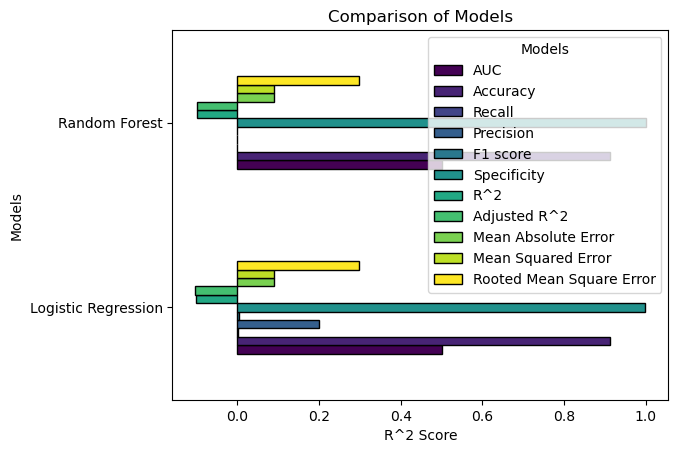

In [41]:
# plot a graphic
plt.figure(figsize=(10, 6))
comparison.plot(kind='barh', colormap='viridis', edgecolor='black')
plt.title('Comparison of Models')
plt.xlabel('R^2 Score')
plt.ylabel('Models')
plt.show()

# Conclusion

We were able to notice different things. In particular, the type, number of medication or number of laboratory procedure did not play an important role. However, we were able to create a correlation matrix which gave us information on the links between the different variables. We found a link between time in the hospital and the number of medications. We saw the differences in readmission between different ethnicities and that age played a major role in readmission.